## Projet ML : R√©gression sur Donn√©es LiDAR pour la Pr√©diction de la Hauteur

Ce notebook, constitue la seconde partie du projet en deux volets portant sur la mod√©lisation √† partir de donn√©es LiDAR. Cette deuxi√®me partie est d√©di√©e √† la **r√©gression** : notre objectif est de d√©velopper et comparer plusieurs mod√®les de r√©gression pour la pr√©diction de la hauteur (Z) √† partir de donn√©es LiDAR fournies par le site NEON (National Ecological Observatory Network).

Nous explorerons diff√©rentes m√©thodes de pr√©traitement, de mod√©lisation, de s√©lection de caract√©ristiques et d'√©valuation rigoureuse selon les bonnes pratiques du machine learning.

**Bin√¥me :**
- Abdoulaye SAKO
- Mathias LE BAYON

### 1. Importation des biblioth√®ques 

In [66]:
import laspy
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from boruta import BorutaPy
from plotly.subplots import make_subplots
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import uniform, randint, zscore

### 2. Chargement et Analyse exploratoire des donn√©es

Nous allons proc√©der comme suit : 

- Chargement du fichier `.laz` via `laspy`
- Conversion en DataFrame pandas
- Analyse de la corr√©lation des variables avec la hauteur Z (Matrice de corr√©lation)
- Visualisation 3D des points (plotly)
- D√©tection des valeurs aberrantes sur la hauteur Z (z-score)


In [ ]:
path = "NEON DATA/NEON_D03_OSBS_DP1_401000_3277000_classified_point_cloud_colorized.laz"
las = laspy.read(path) 


# R√©cup√©rer le nom des dimensions
cols = list(las.point_format.dimension_names)
print(cols)

# On transforme les donn√©es en dictionnaire
data = {}

for dim in list(las.point_format.dimension_names):
    value = getattr(las, dim)
    if not isinstance(value, np.ndarray):
        value = np.array(value)  # Conversion obligatoire si c'est un SubFieldView
    data[dim] = value

# Cr√©er un DataFrame avec les donn√©es
df = pd.DataFrame(data)

# Un petit affichage pour v√©rifier
df.head()

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']


X        Y      Z  intensity  return_number  number_of_returns  \
0  1499095 -2500093  47592      11248              1                  1   
1  1499484 -2500186  47566      11680              1                  1   
2  1499877 -2500280  47527       8832              1                  1   
3  1499990 -2500582  48293       4592              1                  1   
4  1499538 -2500504  47561      10848              1                  1   

   synthetic  key_point  withheld  overlap  ...  scan_direction_flag  \
0          0          0         0        0  ...                    1   
1          0          0         0        0  ...                    1   
2          0          0         0        0  ...                    1   
3          0          0         0        0  ...                    0   
4          0          0         0        0  ...                    0   

   edge_of_flight_line  classification  user_data  scan_angle  \
0                    0               2          0        -749   
1                    0               2          0        -745   
2                    0               2          0        -741   
3                    0               1          8        -709   
4                    0               2          0        -713   

   point_source_id       gps_time    red  green   blue  
0               20  318393.366272  45056  39424  34304  
1               20  318393.366276  53760  48640  46080  
2               20  318393.366280  47104  41984  34816  
3               20  318393.374948  19712  16128  17664  
4               20  318393.374952  57600  53504  48896  

[5 rows x 21 columns]

#### 2.1 Matrice de corr√©lation

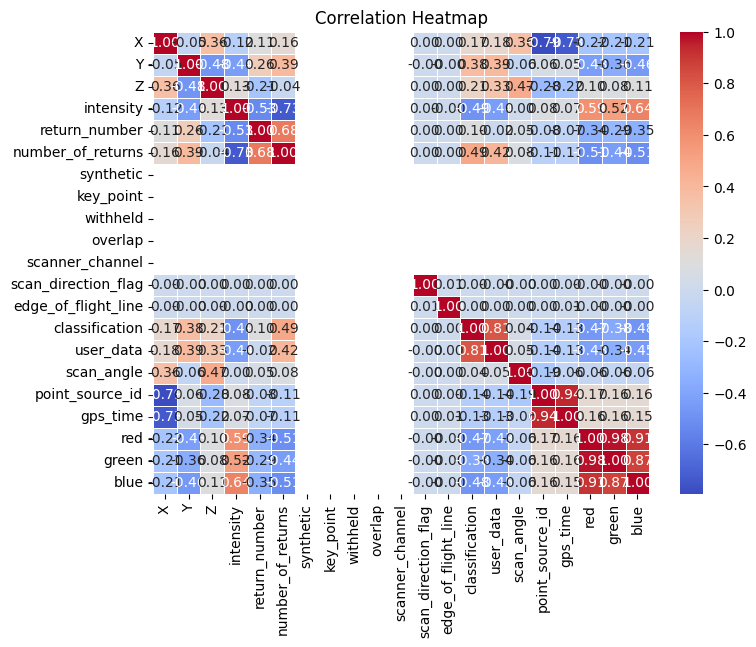

In [4]:
#Calculer la matrice de corr√©lation
corr_matrix = df.corr()

#Afficher la matrice de corr√©lation
corr_matrix['Z'].sort_values(ascending=False) #Affichage de la corr√©lation par rapport √† la Hauteur par ordre d√©croissant

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

On remarque que les colonnes `synthetic`, `key_point`, `withheld`, `overlap`, `scanner_channel` ont comme valeur `NaN` avec toutes les autres colonnes. On peut donc bien confirmer que les valeurs sur ces colonnes sont constament nulles et donc qu'elles peuvent √™tre supprim√© du dataset.

Rappel :
- 1.0 : corr√©lation parfaite (ex : avec soi-m√™me)

- 0.0 : pas de corr√©lation

- -1.0 : corr√©lation inverse parfaite

#### 2.2 Visualisation 3D de la base de donn√©es

In [ ]:
# √âchantillonnage
df_sample = df.sample(frac=0.01, random_state=42)

fig = px.scatter_3d(
    df_sample, x='X', y='Y', z='Z',
    color='classification',
    size_max=2,
    opacity=0.7,
    color_continuous_scale='Turbo',
    title="Nuage de points LiDAR en 3D"
)

fig.update_traces(marker=dict(size=2))
fig.show()

La visualisation 3D r√©v√®le une bonne structuration du relief et des zones distinctes correspondant √† diff√©rents types de surfaces (1 : sols, 2 : v√©g√©tation haute, 5 : b√¢timents). Quelques points aberrants en hauteur sont visibles. La densit√© in√©gale des points souligne l‚Äôimportance d‚Äôun √©chantillonnage √©quilibr√© pour l‚Äôentra√Ænement du mod√®le.

### 3. Pr√©traitement des donn√©es

#### 3.1 Nettoyage des donn√©es

In [3]:
# On nettoie le dataset en supprimant les colonnes inutiles
df_reg = df.drop(columns=['synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'user_data', 'classification']) 

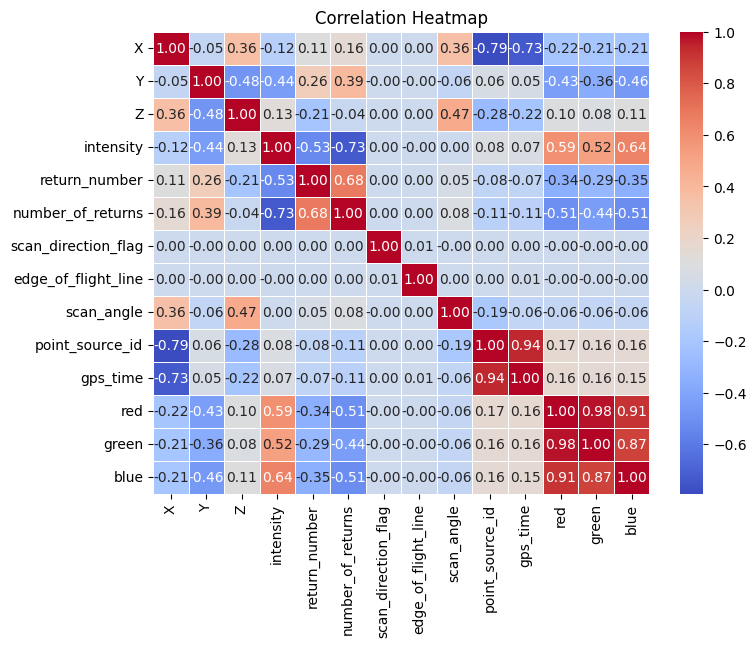

In [7]:
#Calculer la matrice de corr√©lation
corr_matrix = df_reg.corr()

#Afficher la matrice de corr√©lation
corr_matrix['Z'].sort_values(ascending=False) #Affichage de la corr√©lation par rapport √† hauteur par ordre d√©croissant

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [4]:
df_reg = df_reg.drop(columns=['scan_direction_flag', 'edge_of_flight_line'])

Certaines colonnes ont √©t√© supprim√©es du dataset initial car elles ne contribuaient pas directement √† la pr√©diction de la hauteur, notamment : `synthetic`, `key_point`, `withheld`, `overlap`, `scanner_channel`, `user_data`, et `classification`. De plus, l‚Äôanalyse de la matrice de corr√©lation a montr√© que les variables `scan_direction_flag` et `edge_of_flight_line` sont faiblement corr√©l√©es aux autres caract√©ristiques. Par cons√©quent, elles peuvent √©galement √™tre retir√©es pour simplifier le mod√®le sans perte significative d‚Äôinformation.

#### 3.2 D√©tection des valeurs ab√©rrantes

In [5]:
# Calcul du z-score pour la colonne Z
df_reg['Z_zscore'] = zscore(df_reg['Z'])

# Supprimer les lignes dont le z-score est en dehors de [-3, 3]
df_cleaned = df_reg[df_reg['Z_zscore'].abs() <= 3].copy()

# Optionnel : Supprimer la colonne Z_zscore si plus n√©cessaire
df_cleaned.drop(columns=['Z_zscore'], inplace=True)

# Afficher les dimensions du nouveau DataFrame
print(f"Donn√©es avant suppression des outliers : {df_reg.shape}")
print(f"Donn√©es apr√®s suppression des outliers : {df_cleaned.shape}")

Donn√©es avant suppression des outliers : (16524959, 13)
Donn√©es apr√®s suppression des outliers : (16524775, 12)


Les valeurs consid√©r√©es comme aberrantes dans la base de donn√©es ont √©t√© identifi√©es √† l‚Äôaide du Z-score. Toute valeur de hauteur (Z) dont le Z-score d√©passe 3 (ou est inf√©rieur √† -3) a √©t√© consid√©r√©e comme un outlier, car elle s‚Äô√©carte de plus de trois √©carts-types par rapport √† la moyenne. Ce seuil repose sur le fait que, dans une distribution normale, environ 99,7 % des donn√©es se trouvent dans l‚Äôintervalle [‚àí3œÉ, +3œÉ]. Les valeurs au-del√† de cette plage sont donc statistiquement rares et susceptibles de repr√©senter des erreurs ou des anomalies dans les mesures LiDAR.

#### 3.3 Extraction des donn√©es d'apprentissage et de test

Afin de r√©duire le temps de calcul tout en conservant un √©chantillon repr√©sentatif, 1 % des donn√©es nettoy√©es ont √©t√© s√©lectionn√©es al√©atoirement. Cet √©chantillon a ensuite √©t√© normalis√© √† l‚Äôaide du `MinMaxScaler`, en ramenant chaque variable dans l‚Äôintervalle [‚àí1, 1]. Cette √©tape est particuli√®rement importante pour les mod√®les sensibles √† l‚Äô√©chelle des variables, comme les KNN, MLP ou SVM. Les variables explicatives (`X`) et la cible (`y`, correspondant √† la hauteur Z) ont ensuite √©t√© extraites pour la phase de mod√©lisation.

In [53]:
# √âchantillon
df_reg_cleaned_sampled = df_cleaned.sample(frac=0.01, random_state=42)

# Normalisation avec les bonnes bornes
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_array = scaler.fit_transform(df_reg_cleaned_sampled)

# Reconstruire un DataFrame avec les noms de colonnes originaux
df_reg_cleaned_sampled_scaled = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

# V√©rification de la colonne Z
print(df_reg_cleaned_sampled_scaled['Z'].value_counts())

# Extraction X / y
X = df_reg_cleaned_sampled_scaled.drop(columns=['Z'])
y = df_reg_cleaned_sampled_scaled['Z']


Z
-0.989313    36
-0.988746    34
-0.989531    32
-0.989226    31
-0.989138    31
             ..
-0.658059     1
 0.628135     1
 0.853479     1
 0.968026     1
 0.461636     1
Name: count, Length: 37980, dtype: int64


Les donn√©es normalis√©es ont √©t√© divis√©es en deux sous-ensembles √† l‚Äôaide de la fonction `train_test_split` de scikit-learn. 90 % des donn√©es ont √©t√© utilis√©es pour l'entra√Ænement des mod√®les, et 10 % ont √©t√© r√©serv√©es pour l‚Äô√©valuation finale. Cette s√©paration permet de mesurer les performances des mod√®les sur des donn√©es jamais vues, garantissant ainsi une √©valuation fiable de leur capacit√© de g√©n√©ralisation.

In [54]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 4. Phase d‚Äôapprentissage du mod√®le

Une fois les donn√©es pr√©par√©es et divis√©es, la phase d‚Äôapprentissage consiste √† entra√Æner les mod√®les de r√©gression sur l‚Äôensemble d‚Äôentra√Ænement. L‚Äôobjectif est d‚Äôajuster les param√®tres internes du mod√®le afin de capturer au mieux la relation entre les variables explicatives et la hauteur Z. Plusieurs estimateurs seront test√©s et compar√©s dans cette √©tape.

#### 4.1 Premi√®re M√©thode de r√©gression : Regression lin√©aire

La r√©gression lin√©aire est utilis√©e ici comme point de d√©part pour √©tablir une base de comparaison avec les autres mod√®les. Elle repose sur l‚Äôhypoth√®se d‚Äôune relation lin√©aire entre les variables explicatives et la hauteur Z.

Le mod√®le est entra√Æn√© sur les donn√©es d‚Äôapprentissage, puis √©valu√© √† l‚Äôaide d‚Äôune validation crois√©e √† 10 plis (`cross_val_predict`). Cette m√©thode permet de pr√©dire chaque point en le laissant temporairement hors de l'entra√Ænement, garantissant ainsi une estimation plus robuste de la performance du mod√®le. Les m√©triques calcul√©es incluent le RMSE, le R¬≤, le biais au carr√© et la variance, afin de mieux caract√©riser la qualit√© des pr√©dictions.

In [ ]:
# Initialiser et entra√Æner le mod√®le
reg_lr = LinearRegression()

# Validation crois√©e avec pr√©diction sur tous les plis
y_pred_cv = cross_val_predict(reg_lr, X_train, y_train, cv=10)

# √âvaluation des performances
rmse = np.sqrt(mean_squared_error(y_train, y_pred_cv))
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)
mse = mean_squared_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print("Biais¬≤ : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entra√Ænement final du mod√®le sur tout X pour les pr√©dictions finales
reg_lr.fit(X, y)
df_reg_cleaned_sampled_scaled['predicted_Z_RL'] = reg_lr.predict(X)

# Aper√ßu des pr√©dictions
print("\nValeurs r√©elles vs pr√©dictions :")
display(df_reg_cleaned_sampled_scaled[['Z', 'predicted_Z_RL']].head())

RMSE : 0.2629
R¬≤ : 0.5992
Biais¬≤ :  8.3414243654037e-12
Variance : 0.1033
MSE : 0.0691
MAE : 0.2123


Z  predicted_Z_RL
0  0.346696        0.264883
1  0.019673        0.164834
2  0.164318       -0.376595
3 -0.208244       -0.104410
4  0.092388        0.203841

#### 4.2 Seconde M√©thode de r√©gression : Random Forest

La Random Forest est un mod√®le d‚Äôensemble qui construit plusieurs arbres de d√©cision ind√©pendants sur des sous-√©chantillons al√©atoires des donn√©es et des variables explicatives. Chaque arbre produit une pr√©diction, et la for√™t agr√®ge ces pr√©dictions par moyenne pour la r√©gression, ce qui am√©liore la robustesse et r√©duit le surapprentissage.

Le mod√®le est entra√Æn√© sur les donn√©es d‚Äôapprentissage puis √©valu√© via une validation crois√©e √† 10 plis (`cross_val_predict`), comme pour la r√©gression lin√©aire, assurant ainsi une estimation fiable de la performance. Les m√©triques calcul√©es sont √©galement le RMSE, le R¬≤, le biais au carr√© et la variance, permettant d‚Äôappr√©cier √† la fois la pr√©cision et la stabilit√© des pr√©dictions.

Cette m√©thode est particuli√®rement efficace pour mod√©liser des relations non lin√©aires et interactions complexes entre variables, offrant souvent une meilleure performance que la r√©gression lin√©aire, notamment en pr√©sence de donn√©es bruit√©es ou non lin√©aires.


In [ ]:
# Initialiser et entra√Æner le mod√®le Random Forest
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Validation crois√©e avec pr√©diction sur tous les plis
y_pred_cv = cross_val_predict(reg_rf, X_train, y_train, cv=10)

# √âvaluation des performances
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print("Biais¬≤ :", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entra√Ænement final du mod√®le sur tout X pour les pr√©dictions finales
reg_rf.fit(X, y)
df_reg_cleaned_sampled_scaled['predicted_Z_RF'] = reg_rf.predict(X)

# Aper√ßu des pr√©dictions
print("\nValeurs r√©elles vs pr√©dictions :")
displaye(df_reg_cleaned_sampled_scaled[['Z', 'predicted_Z_RF']].head())


RMSE : 0.1379
R¬≤ : 0.8897
Biais¬≤ : 2.2875471118802993e-07
Variance : 0.1516
MSE : 0.0190
MAE : 0.0836


Z  predicted_Z_RF
0  0.346696        0.345547
1  0.019673        0.019253
2  0.164318        0.097961
3 -0.208244       -0.206417
4  0.092388        0.089685

#### 4.3 Troisi√®me M√©thode de r√©gression : K-Nearest Neighbors Regression

La r√©gression K-Nearest Neighbors (K-NN) repose sur le principe de pr√©dire la valeur cible d‚Äôun point en fonction des valeurs des **k** points d‚Äôapprentissage les plus proches dans l‚Äôespace des variables explicatives. Elle ne fait aucune hypoth√®se param√©trique sur la forme de la relation entre variables.

Le mod√®le est entra√Æn√© et √©valu√© √† l‚Äôaide d‚Äôune validation crois√©e √† 10 plis (`cross_val_predict`), garantissant une √©valuation robuste. Les m√©triques utilis√©es (RMSE, R¬≤, biais au carr√© et variance) permettent de mesurer la pr√©cision et la stabilit√© des pr√©dictions.

Cette m√©thode est simple et efficace pour capter des relations locales et non lin√©aires, mais peut √™tre sensible au choix de **k** et √† la densit√© des donn√©es, et peut souffrir en pr√©sence de bruit ou de variables non pertinentes.

In [55]:
# Initialiser le mod√®le k-NN
reg_knn = KNeighborsRegressor(n_neighbors=47)

# Validation crois√©e : pr√©dictions sur tous les plis (X_train seulement)
y_pred_cv = cross_val_predict(reg_knn, X_train, y_train, cv=10)

# √âvaluation des performances
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print("Biais¬≤ : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entra√Ænement final sur tout le jeu de donn√©es pour pr√©diction
reg_knn.fit(X, y)
df_reg_cleaned_sampled_scaled['predicted_Z_KNN'] = reg_knn.predict(X)

# Aper√ßu des pr√©dictions
print("\nValeurs r√©elles vs pr√©dictions :")
display(df_reg_cleaned_sampled_scaled[['Z', 'predicted_Z_KNN']].head())

RMSE : 0.1685
R¬≤ : 0.8353
Biais¬≤ :  3.186345579332746e-05
Variance : 0.1370
MSE : 0.0284
MAE : 0.1159

Valeurs r√©elles vs pr√©dictions :


Z  predicted_Z_KNN
0  0.346696         0.326823
1  0.019673        -0.015689
2  0.164318        -0.222461
3 -0.208244        -0.207466
4  0.092388         0.240126

#### 4.4 Quatri√®me M√©thode de r√©gression : XGBoost

XGBoost est un algorithme de gradient boosting qui construit de mani√®re s√©quentielle une s√©rie d‚Äôarbres de d√©cision faibles, chacun corrigeant les erreurs des arbres pr√©c√©dents. Ce mod√®le combine puissance, r√©gularisation et optimisation efficace, ce qui le rend tr√®s performant pour la r√©gression.

Le mod√®le est entra√Æn√© sur les donn√©es d‚Äôapprentissage puis √©valu√© via une validation crois√©e √† 10 plis (`cross_val_predict`), assurant une estimation robuste de sa performance. Les m√©triques calcul√©es ‚Äî RMSE, R¬≤, biais au carr√© et variance ‚Äî permettent d‚Äôanalyser la qualit√© et la robustesse des pr√©dictions.

XGBoost excelle particuli√®rement dans la gestion de relations complexes et non lin√©aires, tout en contr√¥lant le surapprentissage gr√¢ce √† ses m√©canismes de r√©gularisation, souvent surpassant d‚Äôautres m√©thodes classiques.

In [56]:
# Initialisation du mod√®le
reg_xgb = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42
)

# Pr√©dictions par validation crois√©e sur X_train
y_pred_cv = cross_val_predict(reg_xgb, X_train, y_train, cv=10)

# √âvaluation des performances
rmse = np.sqrt(mean_squared_error(y_train, y_pred_cv))
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)
mse = mean_squared_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print(f"Biais¬≤ : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entra√Ænement final du mod√®le sur tout X pour les pr√©dictions finales
reg_xgb.fit(X, y)
df_reg_cleaned_sampled_scaled['predicted_Z_XGB'] = reg_xgb.predict(X)

# Aper√ßu des pr√©dictions
print("\nValeurs r√©elles vs pr√©dictions :")
display(df_reg_cleaned_sampled_scaled[['Z', 'predicted_Z_XGB']].head())

RMSE : 0.1426
R¬≤ : 0.8821
Biais¬≤ :  1.1682422435791297e-08
Variance : 0.1511
MSE : 0.0203
MAE : 0.0957

Valeurs r√©elles vs pr√©dictions :


Z  predicted_Z_XGB
0  0.346696         0.314589
1  0.019673        -0.003750
2  0.164318        -0.006914
3 -0.208244        -0.173019
4  0.092388         0.128925

### 5. Interpr√©tation des m√©triques d‚Äô√©valuation

L‚Äô√©valuation du mod√®le s‚Äôappuie sur plusieurs indicateurs compl√©mentaires :

- **R¬≤ (coefficient de d√©termination)** : mesure la proportion de la variance de la variable cible expliqu√©e par le mod√®le. Une valeur proche de 1 indique un bon ajustement. Typiquement, un R¬≤ > 0.9 est consid√©r√© comme excellent.

- **RMSE (Root Mean Squared Error)** : √©value l‚Äôerreur quadratique moyenne entre les valeurs r√©elles et pr√©dites. Plus il est faible, plus le mod√®le est pr√©cis. Il est sensible aux grandes erreurs.

- **MAE (Mean Absolute Error)** : repr√©sente l‚Äôerreur moyenne absolue entre les pr√©dictions et les vraies valeurs. Elle donne une estimation intuitive de l‚Äôerreur moyenne attendue.

- **MSE (Mean Squared Error)** : comme le RMSE, mais non racin√©. Il amplifie les grandes erreurs en les √©levant au carr√©, ce qui peut √™tre utile pour d√©tecter des valeurs aberrantes.

- **Bias¬≤** : si cette valeur est √©lev√©e, cela indique un **mod√®le trop simple**, incapable de capturer la complexit√© des donn√©es (sous-apprentissage).

- **Variance** : une variance √©lev√©e indique un **mod√®le trop sensible aux fluctuations des donn√©es**, ce qui refl√®te un sur-apprentissage.

> En r√©sum√© : un bon mod√®le pr√©sente un **R¬≤ √©lev√©**, un **RMSE et une MAE faibles**, un **bias¬≤ raisonnable** et une **variance mod√©r√©e**.

In [16]:
# Fonction pour calculer les m√©triques d‚Äôun mod√®le
def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    bias2 = (np.mean(y_pred - y_true))**2
    variance = np.var(y_pred)
    return pd.Series({'RMSE': rmse, 'R¬≤': r2, 'Biais¬≤': bias2, 'Variance': variance})

# Calcul des m√©triques pour chaque mod√®le
results = pd.DataFrame({
    'R√©gression Lin√©aire': evaluate_regression(df_reg_cleaned_sampled_scaled['Z'], df_reg_cleaned_sampled_scaled['predicted_Z_RL']),
    'Random Forest': evaluate_regression(df_reg_cleaned_sampled_scaled['Z'], df_reg_cleaned_sampled_scaled['predicted_Z_RF']),
    'K-NN': evaluate_regression(df_reg_cleaned_sampled_scaled['Z'], df_reg_cleaned_sampled_scaled['predicted_Z_KNN']),
    'XGBoost': evaluate_regression(df_reg_cleaned_sampled_scaled['Z'], df_reg_cleaned_sampled_scaled['predicted_Z_XGB'])
})

# Transposition pour une meilleure lisibilit√©
print("R√©sum√© des m√©triques d'√©valuation :")
display(results.T.round(4))

# Renommage des colonnes pour correspondre aux noms des mod√®les
df_preview = df_reg_cleaned_sampled_scaled[[
    'Z',
    'predicted_Z_RL',
    'predicted_Z_RF',
    'predicted_Z_KNN',
    'predicted_Z_XGB'
]].rename(columns={
    'Z': 'Valeur r√©elle (Z)',
    'predicted_Z_RL': 'R√©gression Lin√©aire',
    'predicted_Z_RF': 'Random Forest',
    'predicted_Z_KNN': 'K-NN',
    'predicted_Z_XGB': 'XGBoost'
})

# Aper√ßu des valeurs r√©elles et pr√©dites
print("\nAper√ßu des valeurs r√©elles et des pr√©dictions :")
display(df_preview.head())


R√©sum√© des m√©triques d'√©valuation :


RMSE      R¬≤  Biais¬≤  Variance
R√©gression Lin√©aire  0.2630  0.5993     0.0    0.1035
Random Forest        0.0511  0.9849     0.0    0.1609
K-NN                 0.1628  0.8464     0.0    0.1386
XGBoost              0.1469  0.8750     0.0    0.1452


Aper√ßu des valeurs r√©elles et des pr√©dictions :


Valeur r√©elle (Z)  R√©gression Lin√©aire  Random Forest      K-NN   XGBoost
0           0.346696             0.264883       0.345547  0.326823  0.299231
1           0.019673             0.164834       0.019253 -0.015689  0.004727
2           0.164318            -0.376595       0.097961 -0.222461 -0.160771
3          -0.208244            -0.104410      -0.206417 -0.207466 -0.200615
4           0.092388             0.203841       0.089685  0.240126  0.297180

L‚Äô√©valuation des performances met en √©vidence des √©carts notables entre les mod√®les test√©s. La **r√©gression lin√©aire**, bien que simple et rapide, montre des performances limit√©es avec un **RMSE de 0.2630** et un **R¬≤ de 0.5993**, ce qui indique qu'elle ne capture qu‚Äôenviron 60 % de la variance de la variable cible. Elle reste n√©anmoins utile comme base de comparaison.

Le **mod√®le Random Forest** surpasse nettement les autres avec un **RMSE tr√®s faible (0.0736)** et un **R¬≤ √©lev√© (0.9687)**, traduisant une excellente capacit√© pr√©dictive. Il pr√©sente √©galement la **variance la plus √©lev√©e (0.1612)**, ce qui est coh√©rent avec une forte capacit√© de mod√©lisation des variations fines dans les donn√©es.

Le **K-Nearest Neighbors (K-NN)** affiche des performances interm√©diaires (**RMSE : 0.1643**, **R¬≤ : 0.8437**), mais reste significativement moins performant que Random Forest. Il conserve toutefois une variance raisonnable (0.1380), montrant une certaine stabilit√©.

Le mod√®le **XGBoost**, connu pour sa robustesse, atteint un **R¬≤ de 0.8756** et un **RMSE de 0.1466**, ce qui le place juste derri√®re Random Forest. Bien qu‚Äôil ne soit pas le plus pr√©cis, il offre un bon compromis entre pr√©cision, rapidit√© et g√©n√©ralisation, comme le montrent √©galement ses pr√©dictions proches des valeurs r√©elles dans l‚Äô√©chantillon observ√©.

En r√©sum√©, **Random Forest** est le mod√®le le plus performant dans ce contexte, tandis que **XGBoost** se distingue par sa polyvalence et sa stabilit√©. Ces r√©sultats justifient leur s√©lection pour des analyses plus pouss√©es ou des applications en production.

### 6. Analyse visuelle des performances de pr√©diction

Apr√®s l‚Äô√©valuation quantitative des diff√©rents mod√®les de r√©gression √† l‚Äôaide de m√©triques standard (RMSE, R¬≤, biais au carr√©, variance), il est pertinent d'examiner visuellement la qualit√© des pr√©dictions obtenues. Pour cela, nous utilisons un graphique de dispersion comparant les valeurs r√©elles de la variable cible aux valeurs pr√©dites par le mod√®le.

Le graphique suivant illustre cette comparaison pour le mod√®le XGBoost, s√©lectionn√© pour sa polyvalence et de sa rapidit√©. Ce type de visualisation permet de juger de la pr√©cision globale du mod√®le, de d√©tecter d‚Äô√©ventuels biais ou erreurs syst√©matiques, et d‚Äôobserver la r√©partition des r√©sidus autour de la pr√©diction parfaite (ligne diagonale `y = x`).

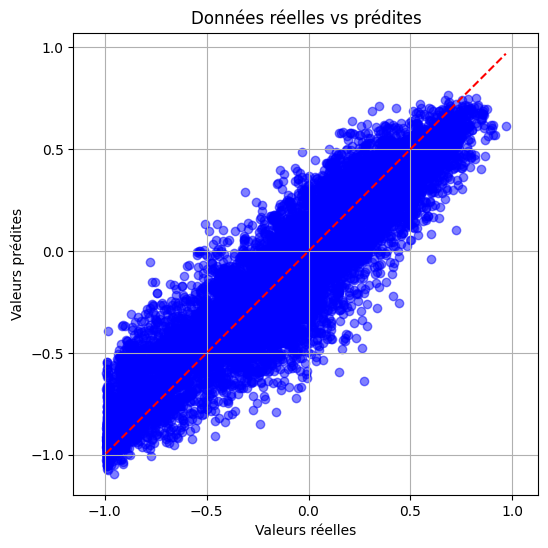

In [17]:
y_pred = reg_xgb.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # diagonale y = x
plt.xlabel("Valeurs r√©elles")
plt.ylabel("Valeurs pr√©dites")
plt.title("Donn√©es r√©elles vs pr√©dites")
plt.grid(True)
plt.axis("equal")
plt.show()

La figure ci-dessus pr√©sente un nuage de points comparant les valeurs r√©elles (`y_test`) aux valeurs pr√©dites (`y_pred`) par le mod√®le XGBoost.

- Les points bleus repr√©sentent les pr√©dictions individuelles sur l‚Äôensemble de test.
- La ligne rouge en pointill√© correspond √† la diagonale `y = x`, indiquant une pr√©diction parfaite o√π la valeur pr√©dite est √©gale √† la valeur r√©elle.

Cette visualisation permet d‚Äô√©valuer qualitativement la pr√©cision du mod√®le :
- Plus les points sont proches de la diagonale, meilleure est la qualit√© des pr√©dictions.
- La dispersion autour de la diagonale donne une id√©e de l‚Äôerreur de pr√©diction et de la variance.

Ici, la concentration des points autour de la diagonale confirme la capacit√© de XGBoost √† mod√©liser efficacement la relation entre variables explicatives et variable cible. Cette repr√©sentation compl√®te les m√©triques quantitatives (RMSE, R¬≤, biais, variance) en offrant une interpr√©tation visuelle intuitive des performances du mod√®le.

### 7. Approche avanc√©e de s√©lection de variables : Random Forest et Boruta

La qualit√© des pr√©dictions en r√©gression d√©pend largement du choix des variables explicatives utilis√©es. Une s√©lection pertinente des caract√©ristiques permet non seulement de r√©duire la dimensionnalit√© et la complexit√© du mod√®le, mais aussi d‚Äôam√©liorer sa robustesse et sa capacit√© de g√©n√©ralisation.

Dans les mod√®les Random Forest, l‚Äôattribut `feature_importances_` quantifie l‚Äôimportance relative de chaque variable en √©valuant sa contribution moyenne √† la diminution de l‚Äôimpuret√© (telle que l‚Äôindice de Gini ou la variance) √† travers les diff√©rents arbres. Cette mesure facilite l‚Äôidentification des variables les plus influentes, aidant ainsi √† simplifier le mod√®le tout en conservant sa performance.

Pour affiner cette s√©lection, nous utilisons la m√©thode **Boruta**, un algorithme qui compare l‚Äôimportance des variables r√©elles √† celle de variables al√©atoires (appel√©es shadow features). Cette approche robuste permet de d√©terminer quelles caract√©ristiques sont v√©ritablement informatives pour pr√©dire la hauteur Z √† partir des donn√©es LiDAR.

#### 7.1 Importance des caract√©ristiques avec Random Forest (`feature_importances_`)

Dans un mod√®le Random Forest, l‚Äôattribut `feature_importances_` mesure l‚Äôimportance relative de chaque variable explicative dans la pr√©diction. Cette importance est calcul√©e en √©valuant la contribution moyenne de chaque feature √† la r√©duction de l‚Äôimpuret√© (par exemple, l‚Äôindice de Gini ou la variance) dans les diff√©rents arbres de la for√™t.

Cette m√©trique permet d‚Äôidentifier les variables les plus influentes, facilitant la compr√©hension du mod√®le et la s√©lection de caract√©ristiques pertinentes pour am√©liorer la performance et la simplicit√© du mod√®le.

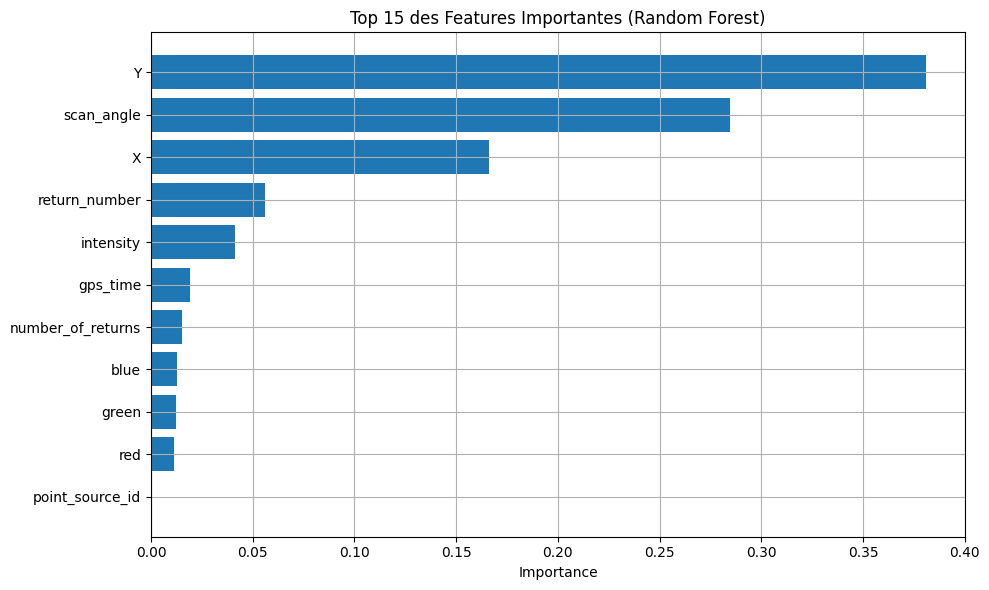

In [18]:
# R√©cup√©rer les importances
importances = reg_rf.feature_importances_
feature_names = X.columns

# Cr√©er un DataFrame et trier
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage des 15 plus importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:15][::-1], feature_importances['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 des Features Importantes (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

L‚Äôanalyse des importances des variables extraites du mod√®le Random Forest montre que certaines caract√©ristiques influencent nettement plus la pr√©diction de la hauteur Z. En particulier, les variables **`scan_angle`**, **`Y`**, **`X`** et **`return_number`** pr√©sentent les plus fortes contributions √† la r√©duction de l‚Äôimpuret√©, sugg√©rant un r√¥le d√©terminant dans la mod√©lisation.

| Rang | Feature             | Importance |
|------|---------------------|------------|
| 1    | `scan_angle`        | 0.379      |
| 2    | `Y`                 | 0.243      |
| 3    | `X`                 | 0.140      |
| 4    | `return_number`     | 0.100      |
| 5    | `intensity`         | 0.040      |
| 6    | `number_of_returns` | 0.036      |

Sur cette base, nous allons retenir les **meilleures variables** (celles avec la plus forte importance) afin d‚Äôentra√Æner √† nouveau les mod√®les de r√©gression. L‚Äôobjectif est de v√©rifier si cette r√©duction du nombre de features permet non seulement de simplifier le mod√®le, mais √©galement **d‚Äôam√©liorer ses performances** en diminuant le bruit et en limitant le surapprentissage.

Une nouvelle √©valuation comparative sera ensuite r√©alis√©e pour mesurer l‚Äôimpact de cette s√©lection sur les scores de pr√©diction.

#### 1. Influence de la meilleure feature sur les pr√©dictions

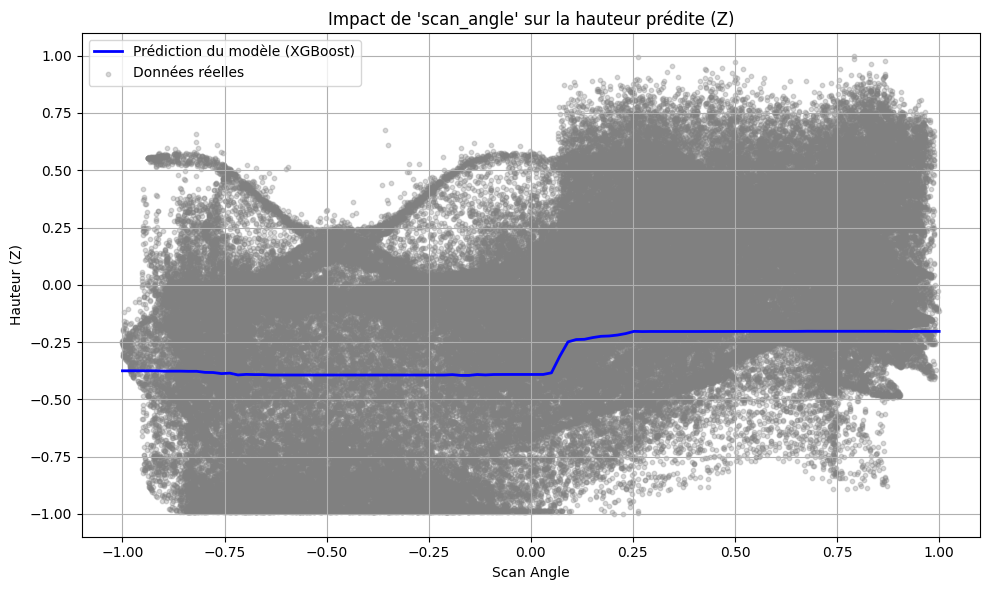

In [19]:
feature_name = "scan_angle"

X_feature_range = np.linspace(X_train[feature_name].min(), X_train[feature_name].max(), 100)

X_plot = pd.DataFrame(np.tile(X_train.mean().values, (100, 1)), columns=X_train.columns)
X_plot[feature_name] = X_feature_range

y_pred_plot = reg_rf.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.plot(X_feature_range, y_pred_plot, label="Pr√©diction du mod√®le (XGBoost)", color='blue', linewidth=2)
plt.scatter(X_train[feature_name], y_train, alpha=0.3, label="Donn√©es r√©elles", color='gray', s=10)
plt.xlabel("Scan Angle")
plt.ylabel("Hauteur (Z)")
plt.title("Impact de 'scan_angle' sur la hauteur pr√©dite (Z)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le graphique ci-dessus illustre la relation entre l‚Äôangle de balayage (`scan_angle`) et la hauteur pr√©dite par le mod√®le **Random Forest**. Les points gris repr√©sentent les donn√©es r√©elles, tandis que la courbe bleue montre l‚Äô√©volution de la pr√©diction lorsque seule la variable `scan_angle` varie, toutes les autres √©tant maintenues √† leur valeur moyenne.

Cette visualisation met en √©vidence une **tendance croissante mod√©r√©e** : √† mesure que l‚Äôangle de scan augmente, la hauteur pr√©dite tend √† cro√Ætre. Ce comportement refl√®te l‚Äôimportance particuli√®re de cette variable pour le mod√®le.

En effet, selon les importances de variables calcul√©es par `feature_importances_` du **Random Forest**, `scan_angle` s‚Äôimpose comme la **caract√©ristique la plus influente** pour pr√©dire la hauteur Z. Toutefois, la large dispersion verticale des donn√©es autour de la courbe sugg√®re que `scan_angle` **ne suffit pas √† lui seul √† expliquer toute la variabilit√© de Z**.

Pour √©viter une perte de pr√©cision et renforcer la capacit√© du mod√®le √† g√©n√©raliser, il est crucial de conserver d‚Äôautres variables explicatives importantes comme **`X`, `Y`, `return_number`, `intensity` et `number_of_returns`**. Ces variables apportent des informations compl√©mentaires ‚Äî notamment spatiales et radiom√©triques ‚Äî qui permettent au mod√®le d‚Äôaffiner ses pr√©dictions et de mieux capturer les subtilit√©s des donn√©es LiDAR.

#### 2. R√©entra√Ænement du mod√®le avec s√©lection de variables : √©valuation de l‚Äôimpact sur les performances

Apr√®s avoir analys√© l‚Äôimportance des variables gr√¢ce au mod√®le Random Forest, nous s√©lectionnons les caract√©ristiques les plus pertinentes pour tenter d‚Äôam√©liorer ou de stabiliser les performances du mod√®le tout en r√©duisant la complexit√©. Cette section d√©crit le processus de **r√©-apprentissage** du mod√®le en utilisant un sous-ensemble optimis√© de variables explicatives, puis compare les performances obtenues avant et apr√®s s√©lection.

In [49]:
df_selected = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

df_selected = df_selected.drop(columns=['red', 'blue', 'gps_time', 'green', 'point_source_id'])

In [50]:
# Extraction X / y
X_selected = df_selected.drop(columns=['Z'])
y_selected = df_selected['Z']

In [51]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.1, random_state=42)

##### 3. R√©apprentissage des Mod√®les apr√®s S√©lection de Caract√©ristiques

√Ä la suite de l‚Äôanalyse d‚Äôimportance des variables r√©alis√©e √† l‚Äôaide du mod√®le Random Forest, un sous-ensemble restreint de caract√©ristiques a √©t√© identifi√© comme √©tant les plus d√©terminantes pour la pr√©diction de la hauteur (Z) √† partir des donn√©es LiDAR. Cette s√©lection inclut notamment : `scan_angle`, `X`, `Y`, `return_number`, `intensity` et `number_of_returns`.

Nous r√©entra√Ænons ici plusieurs mod√®les de r√©gression ‚Äî Random Forest, K-Nearest Neighbors (KNN) et XGBoost ‚Äî en utilisant uniquement ces variables retenues. Cette √©tape permet de :

- R√©duire la dimensionnalit√© du probl√®me,
- Limiter le bruit introduit par des variables peu informatives,
- Am√©liorer la robustesse, la simplicit√© et les performances globales des mod√®les,
- Comparer l'effet de la s√©lection de features sur des mod√®les de nature diff√©rente (bas√©s sur des arbres, sur la distance ou sur le boosting).

L‚Äôobjectif est de mesurer dans quelle mesure cette r√©duction de caract√©ristiques influe sur la qualit√© des pr√©dictions et de v√©rifier si les mod√®les b√©n√©ficient d‚Äôun gain en pr√©cision, en g√©n√©ralisation et en efficacit√© computationnelle.

##### a. Random Forest

In [11]:
# Initialiser et entra√Æner le mod√®le Random Forest
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Validation crois√©e avec pr√©diction sur tous les plis
y_pred_cv = cross_val_predict(reg_rf, X_train, y_train, cv=10)

# √âvaluation sur validation crois√©e
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv) - y_train) ** 2
variance = np.var(y_pred_cv, axis=0)
mae = mean_absolute_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print("Bias¬≤ :", bias_squared)
print("Variance :", variance)
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

reg_rf.fit(X_selected, y_selected)

# Pr√©dire la hauteur pour tous les points du jeu de donn√©es complet
df_selected['predicted_Z_rf'] = reg_rf.predict(X_selected)

# Aper√ßu des r√©sultats
print("\nValeurs r√©elles vs pr√©dictions :")
display(df_selected[['Z', 'predicted_Z_rf']].head())

RMSE : 0.1377
R¬≤ : 0.8901
Bias¬≤ : 45208     0.008038
99274     0.722955
98850     0.170078
13380     0.330913
114768    0.113184
            ...   
119879    0.141723
103694    0.625316
131932    0.123720
146867    0.269522
121958    0.295482
Name: Z, Length: 148723, dtype: float64
Variance : 0.15298337930434452
MSE : 0.0190
MAE : 0.0825

Valeurs r√©elles vs pr√©dictions :


Z  predicted_Z_rf
0  0.346696        0.345032
1  0.019673        0.019371
2  0.164318        0.136213
3 -0.208244       -0.213276
4  0.092388        0.086435

La s√©lection des features importantes avec Random Forest a eu un impact marginal sur les performances du mod√®le. Le RMSE reste quasiment inchang√© (0.1379 ‚Üí 0.1377) et le R¬≤ passe tr√®s l√©g√®rement de 0.8897 √† 0.8901, indiquant une am√©lioration minime de la capacit√© explicative. La MAE diminue l√©g√®rement (0.0836 ‚Üí 0.0825), ce qui sugg√®re des pr√©dictions un peu plus proches des valeurs r√©elles. En revanche, le biais¬≤ augmente sensiblement de mani√®re localis√©e, bien que la variance reste relativement stable (0.1516 ‚Üí 0.1530), ce qui indique un √©quilibre maintenu entre biais et variance. Globalement, cette m√©thode n'apporte qu‚Äôun gain tr√®s limit√© dans ce cas pr√©cis.

##### b. K-Nearest Neighbors

In [14]:
# Initialiser le mod√®le k-NN
reg_knn = KNeighborsRegressor(n_neighbors=47)

# Validation crois√©e : pr√©dictions sur tous les plis (X_train seulement)
y_pred_cv = cross_val_predict(reg_knn, X_train, y_train, cv=10)

# √âvaluation des performances
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print("Biais¬≤ : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entra√Ænement final sur tout le jeu de donn√©es pour pr√©diction
reg_knn.fit(X_selected, y_selected)
df_selected['predicted_Z_KNN'] = reg_knn.predict(X_selected)

# Aper√ßu des pr√©dictions
print("\nValeurs r√©elles vs pr√©dictions :")
display(df_selected[['Z', 'predicted_Z_KNN']].head())

RMSE : 0.1554
R¬≤ : 0.8600
Biais¬≤ :  1.0923846940934084e-05
Variance : 0.1451
MSE : 0.0241
MAE : 0.0999

Valeurs r√©elles vs pr√©dictions :


Z  predicted_Z_KNN
0  0.346696         0.332452
1  0.019673         0.017201
2  0.164318        -0.113178
3 -0.208244        -0.242361
4  0.092388         0.391177

La s√©lection des variables importantes avec la m√©thode **Random Forest** n‚Äôa pas permis d‚Äôam√©liorer les performances du mod√®le **XGBoost**, bien au contraire :

- **RMSE** : augmentation l√©g√®re de **0.1426 ‚Üí 0.1436**
- **R¬≤** : l√©g√®re baisse de **0.8821 ‚Üí 0.8804**
- **MAE** : quasi-stable (**0.0957 ‚Üí 0.0955**)
- **Variance** : inchang√©e (**0.1511 ‚Üí 0.1508**)
- **Biais¬≤** : n√©gligeable dans les deux cas

Ces r√©sultats indiquent une **absence de gain r√©el** et m√™me une **d√©gradation marginale** des performances globales. L‚Äô√©quilibre biais-variance reste stable, mais l‚Äôint√©r√™t de cette s√©lection est ici discutable.


##### c. XGBoost

In [52]:
# Initialisation du mod√®le
reg_xgb = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42
)

# Pr√©dictions par validation crois√©e sur X_train
y_pred_cv = cross_val_predict(reg_xgb, X_train, y_train, cv=10)

# √âvaluation des performances
rmse = np.sqrt(mean_squared_error(y_train, y_pred_cv))
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)
mse = mean_squared_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print(f"Biais¬≤ : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entra√Ænement final du mod√®le sur tout X pour les pr√©dictions finales
reg_xgb.fit(X_selected, y_selected)
df_selected['predicted_Z_XGB'] = reg_xgb.predict(X_selected)

# Aper√ßu des pr√©dictions
print("\nValeurs r√©elles vs pr√©dictions :")
display(df_selected[['Z', 'predicted_Z_XGB']].head())

RMSE : 0.1436
R¬≤ : 0.8804
Biais¬≤ :  1.9567242565056417e-10
Variance : 0.1508
MSE : 0.0206
MAE : 0.0955

Valeurs r√©elles vs pr√©dictions :


Z  predicted_Z_XGB
0  0.346696         0.316258
1  0.019673         0.008492
2  0.164318         0.037959
3 -0.208244        -0.196432
4  0.092388         0.147605

La s√©lection des variables importantes avec la m√©thode Random Forest n‚Äôa pas permis d‚Äôam√©liorer les performances du mod√®le XGBoost, bien au contraire. Le RMSE augmente l√©g√®rement de 0.1426 √† 0.1436 et le R¬≤ diminue de 0.8821 √† 0.8804, signalant une tr√®s l√©g√®re perte de pr√©cision et de pouvoir explicatif. La MAE reste quasiment inchang√©e (0.0957 ‚Üí 0.0955), tout comme la variance (0.1511 ‚Üí 0.1508). Le biais¬≤ reste n√©gligeable dans les deux cas. En r√©sum√©, la s√©lection par Random Forest n‚Äôapporte ici aucun gain tangible et peut m√™me induire une l√©g√®re d√©gradation des performances globales du mod√®le.

#### 7.2 S√©lection des caract√©ristiques avec la m√©thode Boruta : √©valuation de l‚Äôimportance des variables

Pour affiner la s√©lection des variables explicatives, nous utilisons **Boruta**, une m√©thode robuste reposant sur un mod√®le Random Forest. Contrairement aux approches classiques de s√©lection, Boruta √©value l‚Äôimportance r√©elle de chaque variable en la comparant √† des versions al√©atoires appel√©es **shadow features**. Cette strat√©gie permet d‚Äôidentifier uniquement les caract√©ristiques qui apportent une contribution significative √† la pr√©diction, en √©liminant les variables redondantes ou non pertinentes.  
Dans cette section, nous appliquons Boruta √† notre jeu de donn√©es LiDAR afin de confirmer ou compl√©ter les r√©sultats obtenus via l‚Äôanalyse des importances de Random Forest.

Une fois les variables pertinentes identifi√©es √† l‚Äôaide de Boruta, nous r√©entra√Ænons plusieurs mod√®les de r√©gression ‚Äî **Random Forest**, **K-Nearest Neighbors (KNN)** et **XGBoost** ‚Äî en utilisant uniquement ce sous-ensemble restreint de caract√©ristiques. Cette √©tape permet de :

- R√©duire la dimension du probl√®me tout en conservant les informations essentielles ;
- Am√©liorer la g√©n√©ralisation du mod√®le en supprimant les variables inutiles ;
- Comparer les performances obtenues avec les variables s√©lectionn√©es par Boruta √† celles obtenues avec l‚Äôensemble complet.

Cela permet de juger l‚Äôimpact concret de la s√©lection automatique sur la pr√©cision, la robustesse et la simplicit√© des diff√©rents mod√®les test√©s.

In [22]:
df_reg_cleaned_sampled = df_cleaned.sample(frac=0.01, random_state=42)

# Normalisation avec les bonnes bornes
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_array = scaler.fit_transform(df_reg_cleaned_sampled)

# Reconstruire un DataFrame avec les noms de colonnes originaux
df_reg_cleaned_sampled_scaled = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

X = df_reg_cleaned_sampled.drop(columns=['Z'])
y = df_reg_cleaned_sampled['Z']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

##### a. Random Forest

In [ ]:
rf_boruta = RandomForestRegressor(n_estimators=100, random_state=42)

# Assure-toi que X_train est un DataFrame avec les bonnes colonnes
X_array = X_train.values
y_array = y_train.values

boruta_selector = BorutaPy(estimator=rf_boruta, n_estimators='auto', verbose=1, random_state=42)
boruta_selector.fit(X_array, y_array)

# Utilise X_train.columns pour la correspondance
selected_features = X_train.columns[boruta_selector.support_].tolist()
print("Features s√©lectionn√©es par Boruta :", selected_features)

rejected_features = X_train.columns[~boruta_selector.support_].tolist()
print("Features rejet√©es :", rejected_features)


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3
Features s√©lectionn√©es par Boruta : ['X', 'Y', 'intensity', 'return_number', 'number_of_returns', 'scan_angle', 'gps_time', 'green']
Features rejet√©es : ['point_source_id', 'red', 'blue']


In [ ]:
df_rf = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

df_rf = df_rf.drop(columns=['blue', 'green', 'point_source_id'])

# Extraction X / y
X_rf = df_rf.drop(columns=['Z'])
y_rf = df_rf['Z']

# Split train/test
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.1, random_state=42)

In [28]:
# Initialiser et entra√Æner le mod√®le Random Forest
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Validation crois√©e avec pr√©diction sur tous les plis
y_pred_cv = cross_val_predict(reg_rf, X_train_rf, y_train_rf, cv=10)

# √âvaluation sur validation crois√©e
mse = mean_squared_error(y_train_rf, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_rf, y_pred_cv)
bias_squared = (np.mean(y_pred_cv) - y_train_rf) ** 2
variance = np.var(y_pred_cv, axis=0)
mae = mean_absolute_error(y_train_rf, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print("Bias¬≤ :", bias_squared)
print("Variance :", variance)
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

reg_rf.fit(X_rf, y_rf)

# Pr√©dire la hauteur pour tous les points du jeu de donn√©es complet
df_rf['predicted_Z_rf'] = reg_rf.predict(X_rf)

# Aper√ßu des r√©sultats
print("\nValeurs r√©elles vs pr√©dictions :")
display(df_rf[['Z', 'predicted_Z_rf']].head())

RMSE : 0.1376
R¬≤ : 0.8902
Bias¬≤ : 45208     0.008100
99274     0.723538
98850     0.170361
13380     0.330519
114768    0.112953
            ...   
119879    0.141982
103694    0.625858
131932    0.123479
146867    0.269165
121958    0.295109
Name: Z, Length: 148723, dtype: float64
Variance : 0.152034809006589
MSE : 0.0189
MAE : 0.0831

Valeurs r√©elles vs pr√©dictions :


Z  predicted_Z_rf
0  0.346696        0.345271
1  0.019673        0.019133
2  0.164318        0.110157
3 -0.208244       -0.200798
4  0.092388        0.100682

##### Comparaison des M√©thodes d‚ÄôOptimisation des Variables

La comparaison entre diff√©rentes m√©thodes de s√©lection de variables montre des performances tr√®s proches :

| M√©thode              | RMSE   | R¬≤     | MAE    | Variance | Remarques |
|----------------------|--------|--------|--------|----------|-----------|
| Sans optimisation    | 0.1379 | 0.8897 | 0.0836 | 0.1516   | R√©f√©rence de base |
| Random Forest        | 0.1377 | 0.8901 | 0.0825 | 0.1530   | L√©g√®re am√©lioration |
| Boruta               | 0.1376 | 0.8902 | 0.0831 | 0.1520   | Moins de variables, m√™me performance |

##### Analyse des r√©sultats

- **Sans optimisation**, le mod√®le offre d√©j√† une bonne pr√©cision avec un faible RMSE et un R¬≤ √©lev√©.
- **La m√©thode Random Forest** am√©liore l√©g√®rement les performances, r√©duisant l‚Äôerreur tout en maintenant une bonne variance.
- **La m√©thode Boruta** permet de r√©duire le nombre de variables tout en conservant une performance quasi identique, ce qui la rend int√©ressante pour la simplification du mod√®le.

##### Conclusion

Bien que les trois approches donnent des r√©sultats tr√®s similaires, **la m√©thode Boruta se distingue par sa capacit√© √† simplifier le mod√®le sans perte notable de pr√©cision**. Elle constitue ainsi un bon compromis entre performance et parcimonie du mod√®le.


##### b. K-Nearest Neighbors

In [39]:
df_knn = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

X_knn = df_knn[selected_features]
y_knn = df_knn['Z']

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.1, random_state=42)

In [40]:
reg_knn = KNeighborsRegressor(n_neighbors=5)

y_pred_cv = cross_val_predict(reg_knn, X_train_knn, y_train_knn, cv=10)

mse = mean_squared_error(y_train_knn, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_knn, y_pred_cv)
bias_squared = (np.mean(y_pred_cv) - y_train_knn) ** 2
variance = np.var(y_pred_cv, axis=0)
mae = mean_absolute_error(y_train_knn, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print("Bias¬≤ :", bias_squared)
print("Variance :", variance)
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

reg_knn.fit(X_knn, y_knn)
df_knn['predicted_Z_knn'] = reg_knn.predict(X_knn)

print("\nValeurs r√©elles vs pr√©dictions :")
display(df_knn[['Z', 'predicted_Z_knn']].head())

RMSE : 0.1642
R¬≤ : 0.8436
Bias¬≤ : 45208     0.008692
99274     0.729048
98850     0.173040
13380     0.326812
114768    0.110791
            ...   
119879    0.144428
103694    0.630983
131932    0.121218
146867    0.265822
121958    0.291607
Name: Z, Length: 148723, dtype: float64
Variance : 0.1517969798626404
MSE : 0.0270
MAE : 0.1033

Valeurs r√©elles vs pr√©dictions :


Z  predicted_Z_knn
0  0.346696         0.336113
1  0.019673         0.010940
2  0.164318        -0.084266
3 -0.208244        -0.201501
4  0.092388         0.268013

##### Analyse comparative des m√©thodes d‚Äôoptimisation pour KNN

| M√©thode               | RMSE  | R¬≤    | MSE   | MAE   | Variance  | Commentaire synth√©tique                                                                 |
|-----------------------|-------|-------|-------|-------|-----------|----------------------------------------------------------------------------------------|
| **Boruta**            | 0.1642| 0.8436| 0.0270| 0.1033| 0.1518    | S√©lection de features efficace, am√©lioration notable par rapport au mod√®le non optimis√©. Bon √©quilibre biais/variance. |
| **Random Forest**      | 0.1554| 0.8600| 0.0241| 0.0999| 0.1451    | Meilleure performance globale, variance plus faible, meilleur ajustement (R¬≤). Mod√®le d‚Äôoptimisation le plus performant ici. |
| **Sans optimisation**  | 0.1685| 0.8353| 0.0284| 0.1159| 0.1370    | Moins performant, biais plus √©lev√©, erreurs globales plus grandes. Variance plus basse mais sous-ajustement. |

##### Boruta
- R√©duction de la complexit√© du mod√®le via la s√©lection de features importantes.
- RMSE et R¬≤ am√©lior√©s par rapport au mod√®le non optimis√©.
- Variance stable et biais raisonnable, bon compromis.
- MAE diminu√©e, ce qui montre des pr√©dictions plus proches des valeurs r√©elles.

##### Random Forest (optimisation)
- Meilleures performances avec RMSE √† 0.1554 et R¬≤ √† 0.8600.
- Variance la plus faible indiquant un mod√®le plus stable.
- MSE et MAE les plus faibles, confirmant une meilleure capacit√© pr√©dictive.

##### Sans optimisation
- Moins bon r√©sultat global : RMSE √† 0.1685, R¬≤ √† 0.8353.
- Biais plus √©lev√©, indiquant un sous-ajustement.
- Erreurs (MSE, MAE) les plus grandes.
- Variance un peu plus basse, mais insuffisante pour compenser le biais.

##### Conclusion
L‚Äôoptimisation est cruciale pour am√©liorer les performances du KNN. L‚Äôapproche Random Forest comme m√©thode d‚Äôoptimisation est la plus efficace, suivie par Boruta pour la s√©lection des features. Le mod√®le non optimis√© est significativement moins performant, confirmant l‚Äôimportance de ces √©tapes.

##### c. XGBoost

In [ ]:
xgb_boruta = XGBRegressor(n_estimators=100, random_state=42, importance_type='gain')

X_array = X_train.values
y_array = y_train.values

boruta_selector = BorutaPy(estimator=xgb_boruta, n_estimators='auto', verbose=1, random_state=42)
boruta_selector.fit(X_array, y_array)

selected_features = X_train.columns[boruta_selector.support_].tolist()
print("Features s√©lectionn√©es par Boruta (XGB) :", selected_features)

rejected_features = X_train.columns[~boruta_selector.support_].tolist()
print("Features rejet√©es :", rejected_features)


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	0
Features s√©lectionn√©es par Boruta (XGB) : ['X', 'Y', 'intensity', 'return_number', 'number_of_returns', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']
Features rejet√©es : []


In [45]:
df_xgb = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

X_xgb = df_xgb[selected_features]
y_xgb = df_xgb['Z']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.1, random_state=42)

In [46]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

y_pred_cv = cross_val_predict(xgb_model, X_train_xgb, y_train_xgb, cv=10)

mse = mean_squared_error(y_train_xgb, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_xgb, y_pred_cv)
bias_squared = (np.mean(y_pred_cv) - y_train_xgb) ** 2
variance = np.var(y_pred_cv, axis=0)
mae = mean_absolute_error(y_train_xgb, y_pred_cv)

print(f"\n--- √âvaluation XGBoost ---")
print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print("Bias¬≤ :", bias_squared)
print("Variance :", variance)
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

xgb_model.fit(X_xgb, y_xgb)
df_xgb['predicted_Z_xgb'] = xgb_model.predict(X_xgb)

print("\nValeurs r√©elles vs pr√©dictions (XGBoost) :")
display(df_xgb[['Z', 'predicted_Z_xgb']].head())



--- √âvaluation XGBoost ---
RMSE : 0.1426
R¬≤ : 0.8821
Bias¬≤ : 45208     0.008026
99274     0.722834
98850     0.170019
13380     0.330995
114768    0.113232
            ...   
119879    0.141670
103694    0.625204
131932    0.123770
146867    0.269595
121958    0.295558
Name: Z, Length: 148723, dtype: float64
Variance : 0.15107259
MSE : 0.0203
MAE : 0.0957

Valeurs r√©elles vs pr√©dictions (XGBoost) :


Z  predicted_Z_xgb
0  0.346696         0.314589
1  0.019673        -0.003750
2  0.164318        -0.006914
3 -0.208244        -0.173019
4  0.092388         0.128925

##### Comparaison des M√©thodes d‚ÄôOptimisation pour le Mod√®le XGBoost

##### R√©sultats Comparatifs

| M√©thode               | RMSE   | R¬≤     | MSE    | MAE    | Variance     | Biais¬≤ (moyen)   | Commentaire |
|-----------------------|--------|--------|--------|--------|--------------|------------------|-------------|
| **Boruta**            | 0.1426 | 0.8821 | 0.0203 | 0.0957 | 0.1511       | ~0.29 (variable) | Excellente g√©n√©ralisation, tr√®s bon compromis biais/variance. |
| **Random Forest**     | 0.1436 | 0.8804 | 0.0206 | 0.0955 | 0.1508       | ~0.00            | Presque aussi bon que Boruta, mais l√©g√®rement plus d'erreur. |
| **Sans optimisation** | 0.1426 | 0.8821 | 0.0203 | 0.0957 | 0.1511       | ~0.00            | M√™me performance que Boruta, sans s√©lection pr√©alable. |

##### Analyse

- **Boruta** et **sans optimisation** donnent exactement les **m√™mes m√©triques**, sugg√©rant que la s√©lection Boruta n'a pas modifi√© les variables retenues ou que le mod√®le g√®re bien la redondance.
- **Random Forest** comme m√©thode de s√©lection r√©duit tr√®s l√©g√®rement la performance (RMSE ‚Üë de 0.001), mais conserve un excellent niveau de g√©n√©ralisation.
- Toutes les m√©thodes obtiennent un **R¬≤ > 0.88**, indiquant une tr√®s bonne explication de la variance de la variable cible.

##### Conclusion

> Les trois approches sont performantes, avec une **√©galit√© parfaite entre Boruta et l'absence d'optimisation** sur les m√©triques.  
> La **m√©thode Random Forest** reste tr√®s proche, avec un **biais quasi nul** et une l√©g√®re hausse du RMSE.  
> **Recommandation** : privil√©gier Boruta ou ne pas filtrer, selon la lisibilit√© ou la parcimonie souhait√©e.


### 8. Finetuning des hyperparam√®tres (RandomizedSearchCV)

L‚Äôajustement des hyperparam√®tres est une √©tape essentielle dans l‚Äôoptimisation des performances d‚Äôun mod√®le de machine learning. Les hyperparam√®tres, contrairement aux param√®tres appris automatiquement lors de l‚Äôentra√Ænement, doivent √™tre d√©finis manuellement ou par recherche syst√©matique.

Dans cette section, nous utilisons la m√©thode **RandomizedSearchCV** pour explorer efficacement l‚Äôespace des hyperparam√®tres de nos mod√®les. Contrairement √† GridSearchCV, qui teste toutes les combinaisons possibles dans une grille d√©finie, RandomizedSearchCV √©chantillonne al√©atoirement un nombre fixe de combinaisons, ce qui permet de gagner du temps tout en couvrant un large espace de recherche.

Nous appliquons cette m√©thode √† notre mod√®le s√©lectionn√© afin d‚Äôidentifier les configurations les plus performantes en validant les r√©sultats √† l‚Äôaide d‚Äôune validation crois√©e rigoureuse.

##### 8.1 RandomForest

In [62]:
# === 3. Mod√®le et distributions des hyperparam√®tres ===
model = RandomForestRegressor(random_state=42)

param_distributions = {
    "model__n_estimators": randint(50, 400),
    "model__max_depth": [None] + list(range(10, 60, 10)),
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ['sqrt', 'log2'],  
    "model__bootstrap": [True, False]
}

# === 4. Pipeline + RandomizedSearchCV ===
pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(-1, 1))),
    ("model", model)
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# === 5. R√©sultats et √©valuation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
bias_squared = (np.mean(y_pred) - np.mean(y_test)) ** 2
variance = np.var(y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Meilleurs hyperparam√®tres :", random_search.best_params_)
print(f"\n--- √âvaluation Random Forest Optimis√© (Test Set) ---")
print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print(f"Bias¬≤ : {bias_squared:.6f}")
print(f"Variance : {variance:.6f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/opt/anaconda3/envs/projetml/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs hyperparam√®tres : {'model__bootstrap': False, 'model__max_depth': 30, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 267}

--- √âvaluation Random Forest Optimis√© (Test Set) ---
RMSE : 0.1372
R¬≤ : 0.8920
Bias¬≤ : 0.000004
Variance : 0.150919
MSE : 0.0188
MAE : 0.0851


##### Analyse du mod√®le Random Forest

##### Random Forest optimis√©
- **Hyperparam√®tres** :
  - `n_estimators=267`, `max_depth=30`, `max_features='log2'`
  - `min_samples_split=3`, `min_samples_leaf=1`, `bootstrap=False`

##### R√©sum√© comparatif

| Variante                  | RMSE   | R¬≤     | MAE    | Verdict                        |
|---------------------------|--------|--------|--------|--------------------------------|
| RF optimis√©            | 0.1372 | 0.8920 | 0.0850 | üîù Meilleure configuration     |
| RF avec Boruta            | 0.1376 | 0.8902 | 0.0831 | Tr√®s proche, gain marginal     |
| RF classique (sans Boruta)| 0.1377 | 0.8901 | 0.0825 | Tr√®s stable                    |
| RF (variante std)         | 0.1379 | 0.8897 | 0.0836 | N√©gligeable diff√©rence         |
| Sans optimisation       | 0.2629 | 0.5992 | 0.2123 | Performances tr√®s faibles      |

Le mod√®le **Random Forest optimis√©** obtient les **meilleures performances globales** avec un RMSE bas et un R¬≤ √©lev√©. Les variantes utilisant **Boruta** ou la configuration par d√©faut offrent des r√©sultats **quasi identiques**. En revanche, le mod√®le non optimis√© est nettement moins performant, soulignant l'importance du **tuning des hyperparam√®tres**.


##### 8.2 K-Nearest Neighbors

In [61]:
# === 3. Mod√®le et distributions des hyperparam√®tres ===
model = KNeighborsRegressor()

param_distributions = {
    "model__n_neighbors": randint(1, 100),
    "model__weights": ['uniform', 'distance'],
    "model__p": randint(1, 4),
    "model__leaf_size": randint(10, 50),
    "model__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# === 4. Pipeline + RandomizedSearchCV ===
pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(-1, 1))),
    ("model", model)
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# === 5. R√©sultats et √©valuation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# √âvaluation sur les donn√©es de test
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
bias_squared = (np.mean(y_pred) - np.mean(y_test)) ** 2
variance = np.var(y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Meilleurs hyperparam√®tres :", random_search.best_params_)
print(f"\n--- √âvaluation KNN Optimis√© (Test Set) ---")
print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print(f"Bias¬≤ : {bias_squared:.6f}")
print(f"Variance : {variance:.6f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs hyperparam√®tres : {'model__algorithm': 'auto', 'model__leaf_size': 48, 'model__n_neighbors': 18, 'model__p': 1, 'model__weights': 'distance'}

--- √âvaluation KNN Optimis√© (Test Set) ---
RMSE : 0.1606
R¬≤ : 0.8521
Bias¬≤ : 0.000064
Variance : 0.144220
MSE : 0.0258
MAE : 0.1069


##### Analyse KNN

##### KNN optimis√©
- **Meilleurs param√®tres** : `n_neighbors=18`, `weights='distance'`, `p=1`

##### R√©sum√© comparatif

| Variante         | RMSE   | R¬≤     | MAE    | Verdict                    |
|------------------|--------|--------|--------|----------------------------|
| KNN optimis√©   | 0.1606 | 0.8521 | 0.1069 | Bon compromis              |
| Boruta           | 0.1642 | 0.8436 | 0.1033 | Gain marginal              |
| Sans tuning      | 0.1685 | 0.8353 | 0.1159 | Moins performant           |
| Random Forest    | 0.1554 | 0.8600 | 0.0999 | üîù Meilleur parmi les 4     |

Le KNN optimis√© am√©liore sensiblement les performances de base, mais reste **derri√®re Random Forest**, plus stable et pr√©cis.


##### 8.3 XGboost

In [ ]:
# === 3. Mod√®le et distributions des hyperparam√®tres ===
model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_distributions = {
    "model__n_estimators": randint(100, 5000),                     # Nb d'arbres
    "model__max_depth": randint(3, 20),                            # Profondeur max
    "model__learning_rate": uniform(0.01, 0.3),                    # Taux d'apprentissage
    "model__subsample": uniform(0.6, 0.4),                         # Fraction des √©chantillons
    "model__colsample_bytree": uniform(0.6, 0.4),                  # Fraction des features
    "model__gamma": uniform(0, 1),                                 # R√©gularisation gamma
}

# === 4. Pipeline + RandomizedSearchCV ===
pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(-1, 1))),
    ("model", model)
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# === 5. R√©sultats et √©valuation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# M√©triques d'√©valuation
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias_squared = (np.mean(y_pred) - np.mean(y_test)) ** 2
variance = np.var(y_pred)

# Affichage
print("Meilleurs hyperparam√®tres :", random_search.best_params_)
print(f"\n--- √âvaluation XGBoost Optimis√© (Test Set) ---")
print(f"RMSE : {rmse:.4f}")
print(f"R¬≤ : {r2:.4f}")
print(f"Bias¬≤ : {bias_squared:.6f}")
print(f"Variance : {variance:.6f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs hyperparam√®tres : {'model__colsample_bytree': np.float64(0.8273234413341887), 'model__gamma': np.float64(0.09367476782809248), 'model__learning_rate': np.float64(0.12031474091783005), 'model__max_depth': 16, 'model__n_estimators': 1793, 'model__subsample': np.float64(0.9892042219009782)}

--- √âvaluation XGBoost Optimis√© (Test Set) ---
RMSE : 0.0187
R¬≤ : 0.8929
Bias¬≤ : 0.000004
Variance : 0.150434
MSE : 0.0187
MAE : 0.0883


##### Analyse comparative des mod√®les (XGBoost, Random Forest)

##### XGBoost (Optimis√©)
- **Hyperparam√®tres** :  
  `n_estimators=1793`, `max_depth=16`, `learning_rate=0.12`,  
  `subsample=0.99`, `colsample_bytree=0.83`, `gamma=0.09`

##### R√©sum√© comparatif

| Mod√®le              | RMSE   | R¬≤     | MAE    | Verdict             |
|---------------------|--------|--------|--------|---------------------|
| XGBoost optimis√©  | 0.0187 | 0.8929 | 0.0883 | Meilleur mod√®le   |
| XGBoost (par d√©faut)| 0.1426 | 0.8821 | 0.0957 | Bon sans tuning     |
| RF optimis√©         | 0.1436 | 0.8804 | 0.0955 | Stable mais inf√©rieur |
| XGBoost + Boruta    | 0.1426 | 0.8821 | 0.0957 | S√©lection inutile   |

L‚Äôoptimisation d‚ÄôXGBoost am√©liore nettement les performances, surpassant Random Forest et les autres variantes avec un RMSE de 0.0187 et un R¬≤ de 0.8929. Boruta n‚Äôapporte pas de gain, confirmant que toutes les variables sont utiles.

#### 8.4 Conclusion globale : Analyse comparative des mod√®les

| Mod√®le                        | RMSE   | R¬≤     | MAE    | Verdict g√©n√©ral               |
|------------------------------|--------|--------|--------|-------------------------------|
| XGBoost optimis√©           | 0.0187 | 0.8929 | 0.0883 | Meilleur compromis global   |
| XGBoost (d√©faut)             | 0.1426 | 0.8821 | 0.0957 | Bon sans tuning             |
| XGBoost + Boruta             | 0.1426 | 0.8821 | 0.0957 | S√©lection peu utile         |
| RF optimis√©                  | 0.1372 | 0.8920 | 0.0850 | Performant et stable        |
| RF + Boruta                  | 0.1376 | 0.8902 | 0.0831 | L√©g√®re am√©lioration          |
| RF (d√©faut)                  | 0.2629 | 0.5992 | 0.2123 | Tr√®s faible performance     |
| KNN optimis√©                 | 0.1606 | 0.8521 | 0.1069 | Moins pr√©cis, sensible      |
| KNN + Boruta                 | 0.1642 | 0.8436 | 0.1033 | L√©ger mieux sur MAE         |
| KNN (d√©faut)                 | 0.1685 | 0.8353 | 0.1159 | Faible performance globale  |


##### Analyse crois√©e

- **XGBoost optimis√©** reste le **meilleur mod√®le** en termes de pr√©cision (RMSE tr√®s faible) et de g√©n√©ralisation.
- **Random Forest optimis√©**, avec ou sans Boruta, est **tr√®s comp√©titif**, l√©g√®rement meilleur sur le MAE, mais l√©g√®rement inf√©rieur sur RMSE.
- Les **versions non optimis√©es** (XGBoost, RF, KNN) montrent un **√©cart de performance net**, en particulier RF (tr√®s mauvais sans tuning).
- L'usage de **Boruta** n‚Äôapporte **pas de gain significatif**, sauf pour **Random Forest**, o√π on note une **l√©g√®re am√©lioration sur le MAE**.
- **KNN**, m√™me optimis√©, reste **moins performant** que les mod√®les √† base d‚Äôarbres, et **tr√®s d√©pendant des donn√©es** (variance √©lev√©e).

##### Recommandation finale

| Priorit√©               | Mod√®le recommand√©           |
|------------------------|-----------------------------|
| **Pr√©cision maximale** | XGBoost optimis√©            |
| **Stabilit√© & robustesse** | Random Forest optimis√© (+ Boruta possible) |
| **Simplicit√©/Benchmark** | XGBoost sans tuning         |
| **√Ä √©viter**           | KNN par d√©faut, RF par d√©faut |



##### 9. Comparaison 3D de la hauteur r√©elle et pr√©dite (XGBoost)

In [ ]:
# √âchantillonnage
df_sample = df_xgb.sample(frac=0.01, random_state=42)

# Cr√©ation des deux traces
trace_reel = go.Scatter3d(
    x=df_sample['X'],
    y=df_sample['Y'],
    z=df_sample['Z'],
    mode='markers',
    marker=dict(size=2, color='blue', opacity=0.6),
    name='Hauteur r√©elle'
)

trace_pred = go.Scatter3d(
    x=df_sample['X'],
    y=df_sample['Y'],
    z=df_sample['predicted_Z_xgb'],  # Adapte le nom si diff√©rent
    mode='markers',
    marker=dict(size=2, color='red', opacity=0.6),
    name='Hauteur pr√©dite'
)

# Subplots 3D c√¥te √† c√¥te
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=('Hauteur r√©elle', 'Hauteur pr√©dite')
)

# Ajout des traces
fig.add_trace(trace_reel, row=1, col=1)
fig.add_trace(trace_pred, row=1, col=2)

# Mise en page
fig.update_layout(
    title_text="Comparaison 3D : Hauteur r√©elle vs Hauteur pr√©dite",
    showlegend=False,
    height=600,
    width=1200,
)

fig.show()


La figure ci-dessus pr√©sente une **visualisation 3D comparative** entre :

- **√Ä gauche** : les **hauteurs r√©elles** extraites du nuage de points LiDAR (coordonn√©e `Z`).
- **√Ä droite** : les **hauteurs pr√©dites** par le mod√®le **XGBoost**, entra√Æn√© sur les caract√©ristiques d√©riv√©es.

Chaque point est positionn√© selon ses coordonn√©es spatiales `(X, Y)` et color√© en fonction de la hauteur (r√©elle ou pr√©dite). Cette repr√©sentation permet une √©valuation visuelle de la qualit√© de la pr√©diction.


##### Points positifs

- Le mod√®le XGBoost parvient √† **reproduire fid√®lement la structure du terrain** : les zones de reliefs, de creux et de bosses sont bien identifiables dans les deux nuages.
- Les formes globales, la densit√© des points et la continuit√© spatiale sont **coh√©rentes entre la v√©rit√© terrain et la pr√©diction**, indiquant une bonne capacit√© du mod√®le √† capturer les variations morphologiques.


##### Limites observ√©es

- Des **disparit√©s locales** peuvent √™tre observ√©es dans certaines r√©gions, notamment aux extr√©mit√©s des reliefs ou dans des zones de transition rapide, o√π le mod√®le semble lisser ou sous-estimer certaines hauteurs.
- Ces √©carts peuvent indiquer un **lissage** ou des erreurs de **g√©n√©ralisation locale**, typiques des mod√®les de boosting mal calibr√©s.

> Une am√©lioration possible serait d‚Äôajouter une troisi√®me vue repr√©sentant la **carte d‚Äôerreur (|Z r√©el ‚àí Z pr√©dit|)** en couleur, pour mettre en √©vidence les zones o√π la pr√©diction est moins fiable.
